# Introduction

We are presented with a dataset containing aggregated data of DNS activity from different IPs connected to a leading ISP. In this dataset there are IPs that belong to home networks and offices/organizations. The task is to try and differentiate between the two.
The dataset contains a list of IPs (they are scrambled for anonymity) along with general counts of their activity volumes throughout a single weekday. The day is split into 6 time windows, 4 hours each, and we have the number of DNS queries made by the IP (user). The first time window (index 0) starts at 6AM GMT.
We have the following fields in the dataset:
* user_ip - the IP of the user (anonymized).
* count_hour[0-5] - DNS query count in each of the 6 time windows.
* domain_count - Total distinct domains queried in a single day.
* nxdomain_count - Total number of DNS requests answered with NXDOMAIN (DNS equivalent of 404).

# Initial Imports and Data Input

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv("user_dataset_sample.tsv", sep="\t")
print(len(dataset))
print(dataset.columns)

200000
Index([u'user_ip', u'count_hour0', u'count_hour1', u'count_hour2',
       u'count_hour3', u'count_hour4', u'count_hour5', u'domain_count',
       u'nxdomain_count'],
      dtype='object')


In [3]:
dataset.head()

,user_ip,count_hour0,count_hour1,count_hour2,count_hour3,count_hour4,count_hour5,domain_count,nxdomain_count
0,0.0.102.79,101.0,843.0,1788.0,1833.0,2526.0,2212.0,2456,82
1,0.0.129.25,220.0,866.0,262.0,355.0,488.0,739.0,1188,3
2,0.0.144.177,73.0,145.0,139.0,108.0,76.0,121.0,36,1
3,0.0.167.184,10.0,15.0,114.0,30.0,156.0,229.0,85,5
4,0.0.177.228,508.0,1230.0,798.0,837.0,762.0,602.0,661,2


In [4]:
dataset.fillna(0, inplace=True) # NULLs are actually 0
dataset["query_count"] = sum([dataset["count_hour{}".format(window)] for window in xrange(6)])
for window in xrange(6):
    dataset["count_hour{}_norm".format(window)] = dataset["count_hour{}".format(window)]/dataset.query_count


In [5]:
# Cleanup, remove outliers and IPs with too little requests
dataset = dataset[(dataset.query_count >= 20) & (dataset.query_count <= 1e6)]
print len(dataset)

172369


# General Data Exploration

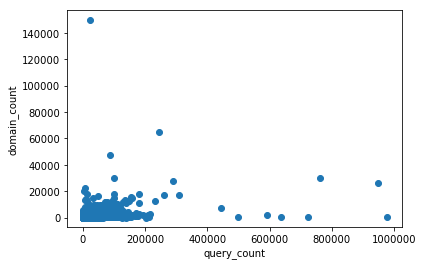

In [6]:
plt.figure()
feat1, feat2 = ["query_count", "domain_count"]
plt.scatter(dataset[feat1], dataset[feat2])
plt.xlabel(feat1); plt.ylabel(feat2)
plt.show()

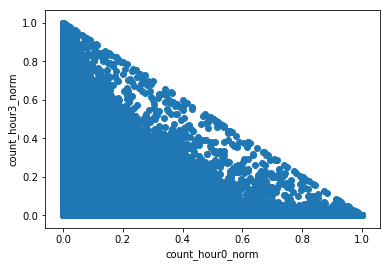

In [7]:
plt.figure()
feat1, feat2 = ["count_hour0_norm", "count_hour3_norm"]
plt.scatter(dataset[feat1], dataset[feat2])
plt.xlabel(feat1); plt.ylabel(feat2)
plt.show()

# Data Clustering Pipeline

In [8]:
selected_features = ["query_count", "domain_count"] + ["count_hour{}_norm".format(hour) for hour in xrange(6)]
X = dataset[:200000].set_index("user_ip")[selected_features]
X.head()

,query_count,domain_count,count_hour0_norm,count_hour1_norm,count_hour2_norm,count_hour3_norm,count_hour4_norm,count_hour5_norm
user_ip,,,,,,,,
0.0.102.79,9303.0,2456,0.010857,0.090616,0.192196,0.197033,0.271525,0.237773
0.0.129.25,2930.0,1188,0.075085,0.295563,0.089420,0.121160,0.166553,0.252218
0.0.144.177,662.0,36,0.110272,0.219033,0.209970,0.163142,0.114804,0.182779
0.0.167.184,554.0,85,0.018051,0.027076,0.205776,0.054152,0.281588,0.413357
0.0.177.228,4737.0,661,0.107241,0.259658,0.168461,0.176694,0.160861,0.127085


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

scaler = StandardScaler()
clusterer = KMeans(n_clusters=2)
pca = PCA(n_components=8)

clustering_pipe = PMMLPipeline([ # We can use sklearn.pipeline but we use the PMML extension that we can later export
    ('scaler', scaler),
    ('clusterer', clusterer),
])


In [10]:
categories = clustering_pipe.fit_predict(X)

In [11]:
result = X.reset_index()[["user_ip"]].set_index("user_ip")
result["prediction"] = categories
result.to_csv("clusters_python.csv")

## Visualization

Let's look at how the clustering works on several intersections of the data

In [12]:
N = 30000
X0 = X[categories==0][:N]
X1 = X[categories==1][:N]


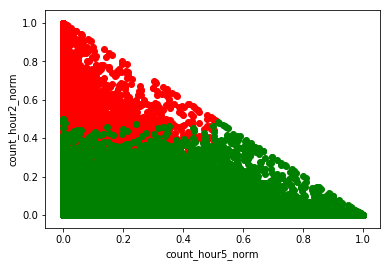

In [13]:
plt.figure()
feat1, feat2 = ["count_hour5_norm", "count_hour2_norm"]
plt.scatter(X0[feat1], X0[feat2], c='r')
plt.scatter(X1[feat1], X1[feat2], c='g')
plt.xlabel(feat1); plt.ylabel(feat2)
plt.show()

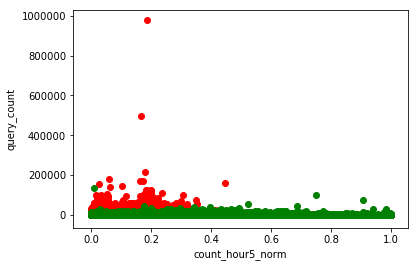

In [14]:
plt.figure()
feat1, feat2 = ["count_hour5_norm", "query_count"]
plt.scatter(X0[feat1], X0[feat2], c='r')
plt.scatter(X1[feat1], X1[feat2], c='g')
plt.xlabel(feat1); plt.ylabel(feat2)
plt.show()

We can also try and reduce the dimensionality to get a sense of how the clustering works on a combination of all the features. Note that the dimensionality reduction (PCA in this case) is lossy.

In [15]:
from sklearn.pipeline import Pipeline
scaler_vis = StandardScaler()
pca_vis = PCA(n_components=2)

pca_pipe = Pipeline([
    ('scaler', scaler_vis),
    ('pca', pca_vis),
])
X_pca = pca_pipe.fit_transform(X)


In [16]:
N = 50000
X0_pca = X_pca[categories==0][:N]
X1_pca = X_pca[categories==1][:N]


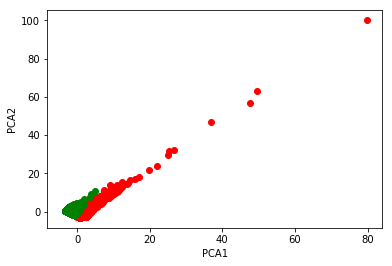

In [17]:
plt.figure()
plt.scatter(X0_pca[:,0], X0_pca[:,1], c='r')
plt.scatter(X1_pca[:,0], X1_pca[:,1], c='g')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

## Validation

For validation purposes we've generated a list of IPs that we believe belong to organizations, using an independent heuristic logic. The logic relies on the specific domains accessed by the IPs, which we are not allowed to publish.
A nice measure for the clustering success is to have the organizations in the same class. Ideally, we would like to have all of them in the same class.

In [18]:
organization_ips = pd.read_csv("organizations.csv")
organization_features = organization_ips.merge(dataset, on="user_ip").drop_duplicates()
print len(organization_features)

84


In [19]:
organization_ip_set = set(organization_ips.user_ip)

In [20]:
X_orgs = X[X.index.isin(organization_ip_set)]
X_orgs_pca = X_pca[X.index.isin(organization_ip_set)]
print len(X_orgs)

84


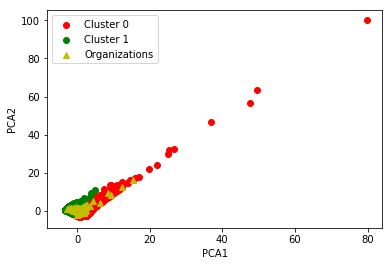

In [21]:
plt.figure()
plt.scatter(X0_pca[:,0], X0_pca[:,1], c='r', label="Cluster 0")
plt.scatter(X1_pca[:,0], X1_pca[:,1], c='g', label="Cluster 1")
plt.scatter(X_orgs_pca[:,0], X_orgs_pca[:,1], c='y', marker='^', label="Organizations")
plt.legend(loc="best")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

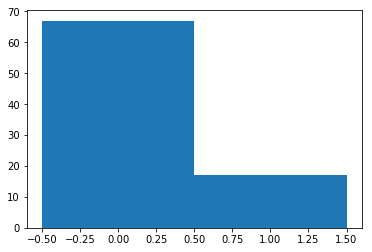

array([ 0.79761905,  0.20238095])

In [22]:
org_categories = clustering_pipe.predict(X_orgs)
plt.figure()
n, bins, _ = plt.hist(org_categories, bins=[-0.5,0.5,1.5])
plt.show()
n/sum(n)

So, 80% of the organizations fall under the same cluster. Might not sound impressive, but given the density of the data it is actually not too bad. That is, so long as the cluster is not 3 times large than the other cluster. Let's see if that is the case.

In [23]:
X0 = X[categories==0]
X1 = X[categories==1]
print len(X0), len(X1)
n/np.array([len(X0), len(X1)])

110416 61953


array([ 0.0006068,  0.0002744])

So the organization cluster is actually twice the size of cluster 0. This weakens the results a bit but it's still much better than a 50-50 guess.

# Exporting the Clustering Pipeline

Next, we want to export the pipeline for later use in a different system (Spark over Scala in this case). We use PMML for that.

In [24]:
sklearn2pmml(clustering_pipe, "clustering_pipeline.pmml")